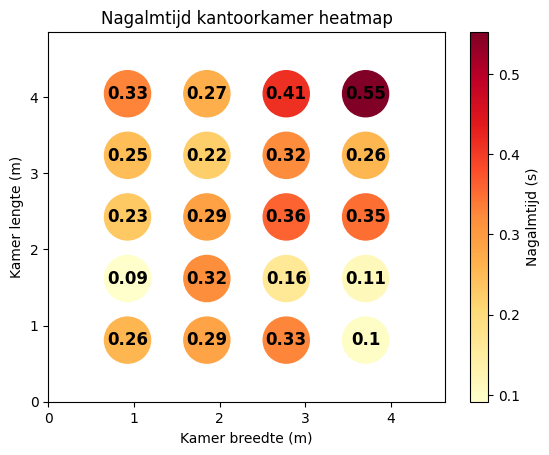

In [1]:
# This script will generate a heatmap with the values generated in the 'nagalmtijden.csv' from the 'record & process.ipynb' script.

import math
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("nagalmtijden.csv", delimiter=",")

# Define the dimensions of the room
room_length = 4.85 # in meters
room_width = 4.63 # in meters

def average_reverb_time_for_each_unique_point():
    # Create an empty list to store the results
    results = []

    # Loop through the unique values in the "punten" column
    for punten in df['punten'].unique():
        # Select the rows where "punten" equals the current value
        mask = df['punten'] == punten
        rows = df[mask]

        # Calculate the average of the "nagalmtijd" column for those rows
        nagalmtijd_avg = rows['nagalmtijd'].mean()

        # Add the results to the list
        results.append({'punten': punten, 'average_nagalmtijd': nagalmtijd_avg})

    return pd.DataFrame(results)

# Average the 'nagalmtijd' for each unique point to have more accurate results.
df = average_reverb_time_for_each_unique_point()

def calculate_point_positions():
    # Define amount of spaces between points on width & length of room
    amount_of_white_spaces_width = 5
    amount_of_white_spaces_length = 6

    # Define amount of points on width axis
    amount_of_points_width = 4

    # Calculate step size of X-axis & Y-axis  between each point
    x_step_size = room_width / amount_of_white_spaces_width
    y_step_size = room_length / amount_of_white_spaces_length

    # Fill array with values to prevent 'array index out of range' error in loop
    positions = [[-1, -1] for _ in range(len(df.index))]
    for index, row in df.iterrows():
        punt = row['punten']

        # Calculate index of column, to calculate position on X-axis
        columnIndex = punt % amount_of_points_width
        if columnIndex == 0:
            columnIndex = 4
        x = columnIndex * x_step_size

        # Calculate index of ROW, to calculate position on y-axis
        rowIndex = math.ceil(punt / amount_of_points_width)
        y = rowIndex * y_step_size

        # Add X & Y coordinates to array
        positions[index] = [x, y]
    # Return array of point positions
    return positions

# Define the X-axis & Y-axis values for the heatmap
positions = calculate_point_positions()
x_positions = [inner_list[0] for inner_list in positions]
y_positions = [inner_list[1] for inner_list in positions]

# Define the values for the heatmap
# In this example, the values represent temperature at each point in the room
heatmap_values = df['average_nagalmtijd']

# Create the heatmap using Matplotlib's scatter() function
fig, ax = plt.subplots()
im = ax.scatter(x_positions, y_positions, c=heatmap_values, cmap='YlOrRd', s=1100)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Nagalmtijd (s)')

# Set the X and Y axis labels for the heatmap
ax.set_xlabel('Kamer breedte (m)')
ax.set_ylabel('Kamer lengte (m)')

# Room limits
ax.set_xlim(0, room_width)
ax.set_ylim(0, room_length)

# Set the title of the heatmap
ax.set_title("Nagalmtijd kantoorkamer heatmap")

# Add text annotations for each point
for i, value in enumerate(heatmap_values):
    ax.text(x_positions[i], y_positions[i], round(value, 2),
            ha='center', va='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()
